In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

In [5]:
stations_point = gpd.read_file('../data/processed/stations_point.geojson')
stations_area = gpd.read_file('../data/processed/stations_area.geojson')
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')
rent = pd.read_csv('../data/processed/neighbourhoods_rent.csv')
crime = pd.read_csv('../data/processed/neighbourhoods_crime.csv')
collision = pd.read_csv('../data/processed/neighbourhoods_collision.csv')

In [6]:
crime['hood_id'] = crime['hood_id'].astype(str)
collision['hood_id'] = collision['hood_id'].astype(str)

In [12]:
neighbourhoods_rent = neighbourhoods[['hood_id', 'district', 'geometry']].drop_duplicates().merge(rent, on='district')
neighbourhoods_crime = neighbourhoods[['hood_id', 'geometry']].drop_duplicates().merge(crime, on='hood_id')
neighbourhoods_collision = neighbourhoods[['hood_id', 'geometry']].drop_duplicates().merge(collision, on='hood_id')

# All-in plot

Text(0.5, 402.23608550009055, 'Longitude')

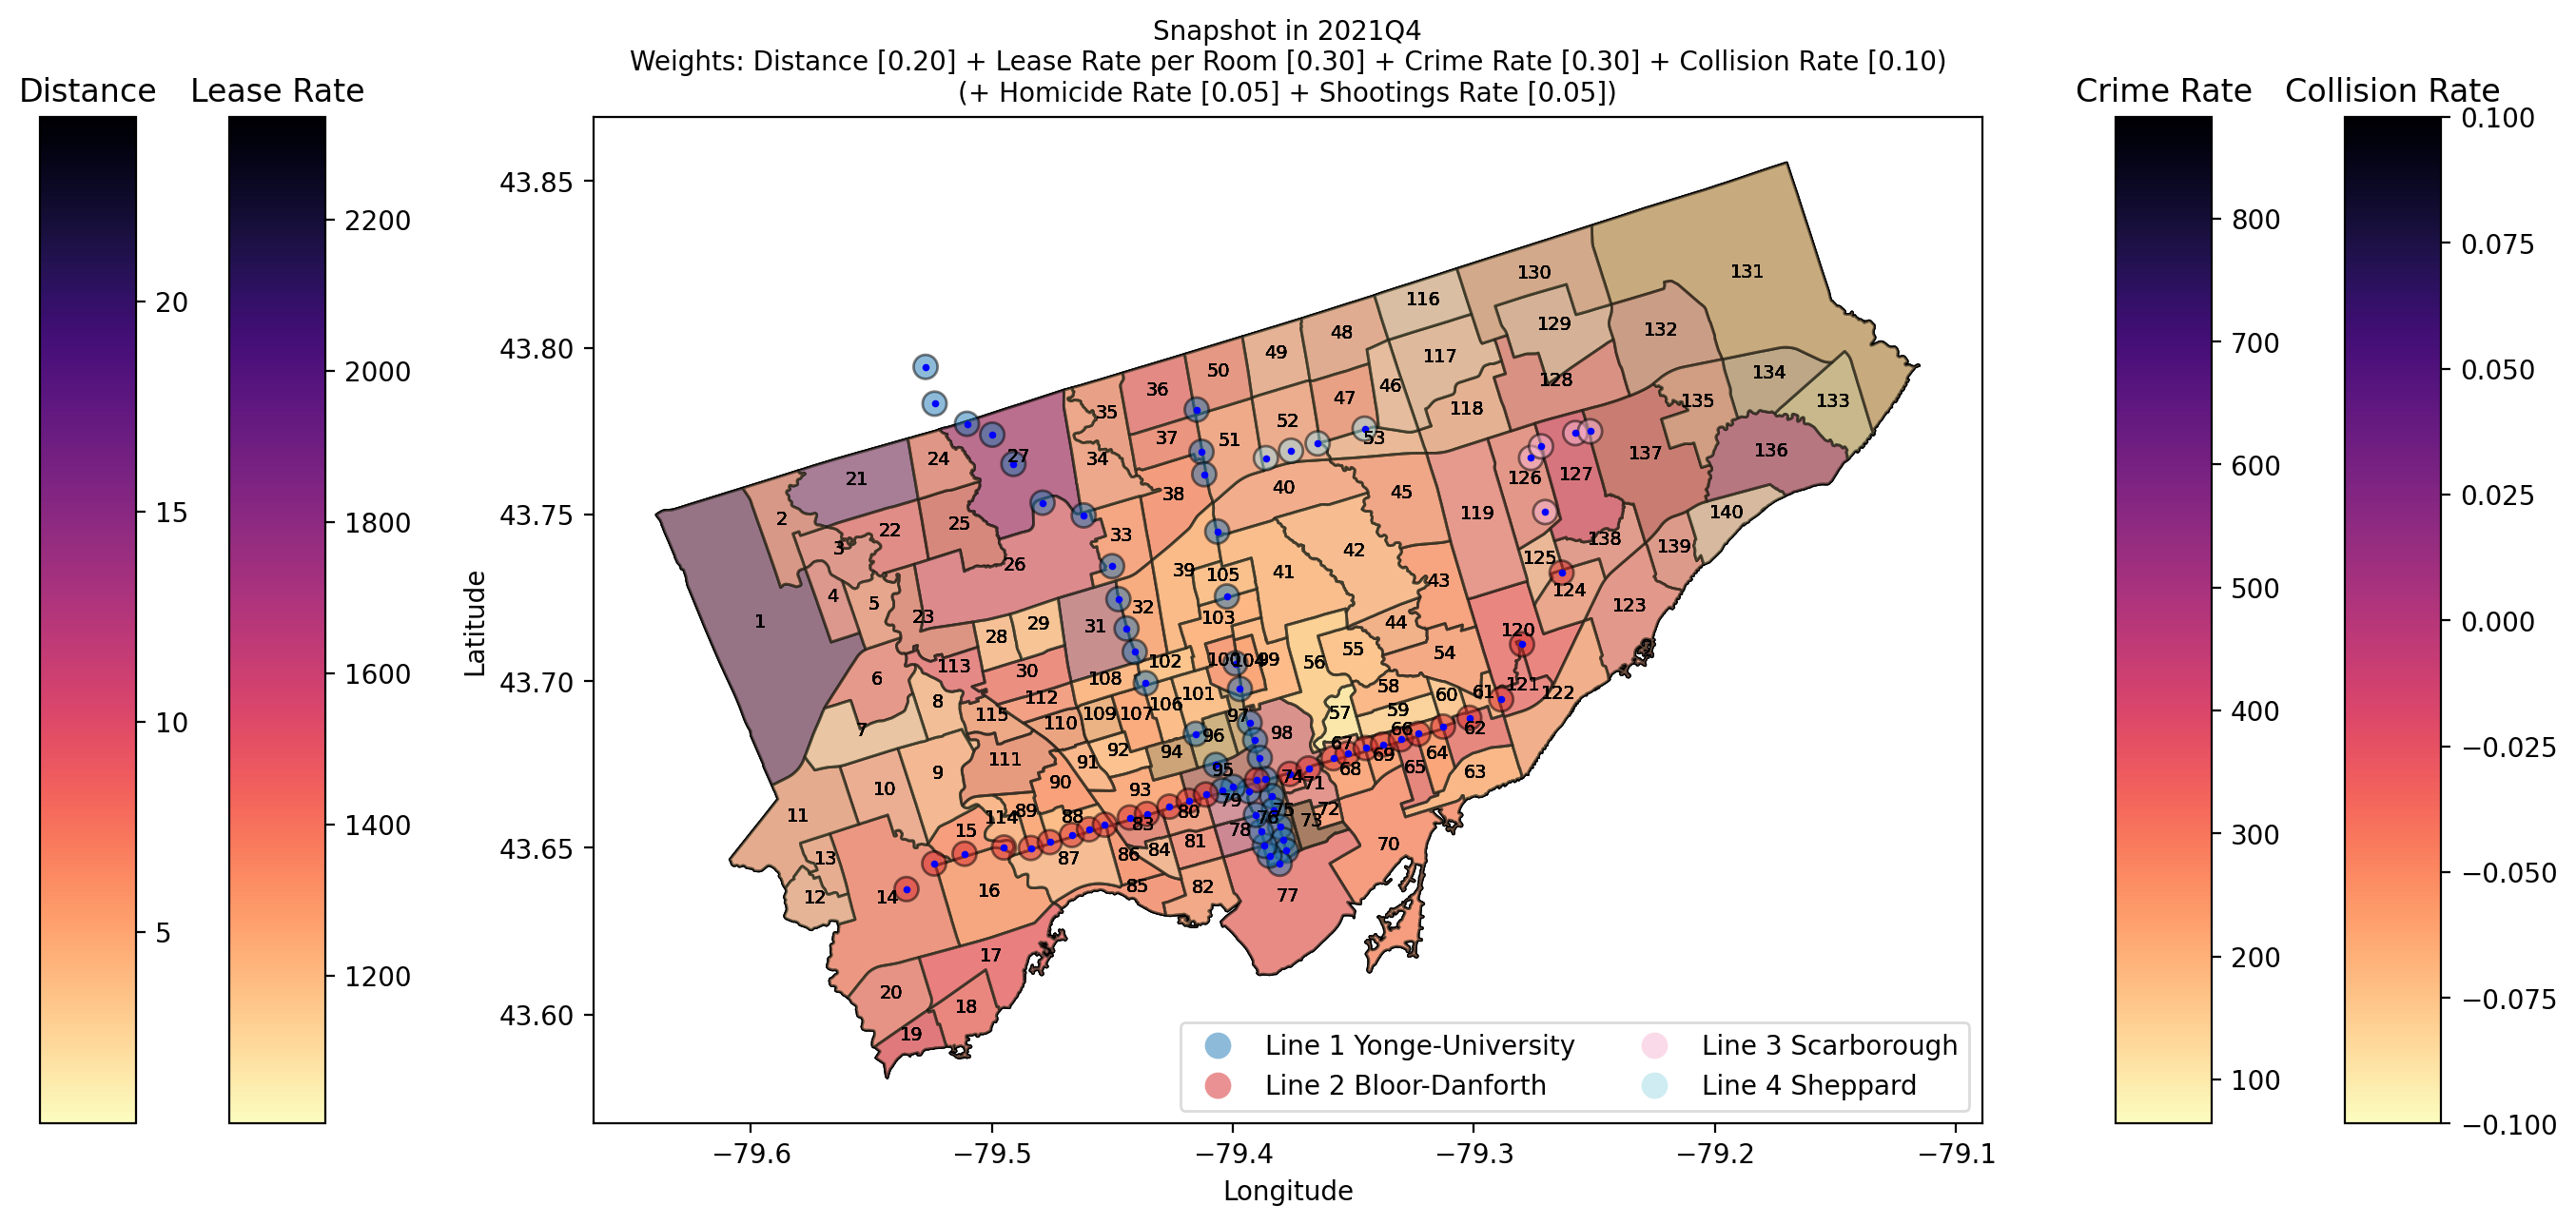

In [28]:
year = 2021
quarter = 4

# weights for coloring
alphas = {'distance': 0.2,
          'rent': 0.3,
          'safety': 0.3,
          'safety_homicide': 0.05,
          'safety_shootings': 0.05,
          'traffic': 0.1}

# alphas = {'distance': 0,
#           'rent': 0,
#           'safety': 0.3,
#           'safety_homicide': 0,
#           'safety_shootings': 0,
#           'traffic': 0}

# multiplier for better contrast
multiplier = 1.5
for key, value in alphas.items():
    alphas[key] = value * multiplier

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=1)
cax.title.set_text('Distance')
neighbourhoods.plot(column='distance_km',
                    cmap= 'bwr',
                    edgecolor='black',
                    alpha=alphas['distance'],
                    ax=ax,
                    cax=cax,
                    legend=True,
                    )
# annotate neighbourhood names
for geometry, label in zip(neighbourhoods.geometry, neighbourhoods.hood_id):
    ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y),
                ha='center', size='x-small')


room_type = 'SharedApartments'
selected_rent = neighbourhoods_rent.loc[(neighbourhoods_rent['Year'] == year) &
                                        (neighbourhoods_rent['Quarter'] == quarter) &
                                        (neighbourhoods_rent['RoomType'] == room_type)]
cax2 = divider.append_axes("left", size="5%", pad=-1.5)
cax2.title.set_text('Lease Rate')
selected_rent.plot(column='AvgLeaseRatePerRoom',
                   cmap='bwr',
                   edgecolor='black',
                   alpha=alphas['rent'],
                   ax=ax,
                   cax=cax2,
                   legend=True,
                   )


var = 'MCI'
selected_crime = neighbourhoods_crime.loc[(neighbourhoods_crime['occurrence_year'] == year) &
                                          (neighbourhoods_crime['occurrence_quarter'] == quarter) &
                                          (neighbourhoods_crime['MCI'] == var) &
                                          (neighbourhoods_crime['type'] == 'rate')]
cax3 = divider.append_axes("right", size="5%", pad=-0.7)
cax3.title.set_text('Crime Rate')
selected_crime.plot(column='value',
                    cmap='bwr',
                    edgecolor='black',
                    alpha=alphas['safety'],
                    ax=ax,
                    cax=cax3,
                    legend=True
                    )

var = "Homicide"
selected_crime = neighbourhoods_crime.loc[(neighbourhoods_crime['occurrence_year'] == year) &
                                          (neighbourhoods_crime['occurrence_quarter'] == quarter) &
                                          (neighbourhoods_crime['MCI'] == var) &
                                          (neighbourhoods_crime['type'] == 'rate')]
selected_crime.plot(column='value',
                    cmap='bwr',
                    edgecolor='black',
                    alpha=alphas['safety_homicide'],
                    ax=ax,
                    #   cax = cax3,
                    #   legend = True
                    )

var = "Shootings"
selected_crime = neighbourhoods_crime.loc[(neighbourhoods_crime['occurrence_year'] == year) &
                                          (neighbourhoods_crime['occurrence_quarter'] == quarter) &
                                          (neighbourhoods_crime['MCI'] == var) &
                                          (neighbourhoods_crime['type'] == 'rate')]
selected_crime.plot(column='value',
                    cmap='bwr',
                    edgecolor='black',
                    alpha=alphas['safety_shootings'],
                    ax=ax,
                    #   cax = cax3,
                    #   legend = True
                    )

var = "collision"
selected_collision = neighbourhoods_collision.loc[(neighbourhoods_collision['occurrence_year'] == year) &
                                                  (neighbourhoods_collision['occurrence_quarter'] == quarter) &
                                                  (neighbourhoods_collision['collision_type'] == var) &
                                                  (neighbourhoods_collision['type'] == 'rate')]
cax4 = divider.append_axes("right", size="5%", pad=0.7)
cax4.title.set_text('Collision Rate')
selected_collision.plot(column='value',
                        cmap='bwr',
                        edgecolor='black',
                        alpha=alphas['traffic'],
                        ax=ax,
                        cax=cax4,
                        legend=True)

stations_area.plot(column='line',
                   edgecolor='black',
                   alpha=0.5,
                   cmap='tab20',
                   legend=True,
                   legend_kwds={'loc': 'lower right',
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                   ax=ax)
stations_point.plot(ax=ax,
                    color='blue',
                    markersize=3)

# reset the alphas to their original values
for key, value in alphas.items():
    alphas[key] = value / multiplier

ax.set_title(f"Snapshot in {year}Q{quarter}\nWeights: Distance [{alphas['distance']:0.2f}] + Lease Rate per Room [{alphas['rent']:0.2f}] + Crime Rate [{alphas['safety']:0.2f}] + Collision Rate [{alphas['traffic']:0.2f})\n(+ Homicide Rate [{alphas['safety_homicide']:0.2f}] + Shootings Rate [{alphas['safety_shootings']:0.2f}])",
             size='medium')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")


# Improvement
- add number of listing per room type
  - currently only number of leased is available
- replace distance with commute time 